# On-Policy Reinforcement Learning with Parmetric Policy

In [25]:
import numpy as np
import lqg1d
import matplotlib.pyplot as plt
import utils
import tqdm

### Experiments parameters

In [26]:
# We will collect N trajectories per iteration
N = 100
# Each trajectory will have at most T time steps
T = 100
# Number of policy parameters updates
n_itr = 100
# Set the discount factor for the problem
discount = 0.9
# Learning rate for the gradient update
learning_rate = 0.01
# Optimal
theta_opt = -0.59

### Update Rule

In [35]:
class ConstantStep(object):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate

    def update(self, gt):
        return self.learning_rate * gt


class AdamStep(object):
    def __init__(self, learning_rate):
        self.m = 0
        self.v = 0
        self.t = 0
        self.alpha = learning_rate

    def update(self, gt, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.t += 1
        self.m = beta1 * self.m + (1 - beta1) * gt
        self.v = beta2 * self.v + (1 - beta2) * (gt * gt)
        m_ = self.m / (1 - beta1 ** self.t)
        v_ = self.v / (1 - beta2 ** self.t)
        return self.alpha * m_ / (np.sqrt(v_) + epsilon)

# REINFORCE

In [28]:
def REINFORCE(policy, T, step, n_itr, N):
    mean_parameters = []
    avg_return = []
    for i in  tqdm.tqdm(range(n_itr), desc="M"):
        paths = utils.collect_episodes(env, policy=policy, horizon=T, n_episodes=N)

        gradJ_MC = 0.
        reward_MC = 0.
        for n in range(N):
            reward = 0.
            gradLogPi = 0.
            for t in range(T):
                a = paths[n]['actions'][t]
                s = paths[n]['states'][t]
                r = paths[n]['rewards'][t]
                gradLogPi += (a-s*policy.theta)*s/(policy.sigma ** 2)
                reward += r * (discount ** t)
            gradJ = reward * gradLogPi
            gradJ_MC += gradJ
            reward_MC += reward

        gradJ_MC = gradJ_MC / N
        reward_MC = reward_MC / N
        
        policy.theta += step.update(gradJ_MC)
        mean_parameters.append(np.asscalar(policy.theta))
        avg_return.append(reward_MC)
    return mean_parameters, avg_return

## Environement

**We will take an initial theta equal to 0. Different tests were done and it is the one which gives the best results. For other initial values, it can totally diverge !**

In [29]:
class Policy:
    def __init__(self, sigma, theta):
        self.sigma = sigma
        self.theta = theta

    def draw_action(self, s):
        return np.random.normal(self.theta * s, self.sigma)   

env = lqg1d.LQG1D(initial_state_type='random')
policy = Policy(0.5, 0)

## Constant Step

M: 100%|███████████████████████████████████████████████████████| 100/100 [05:21<00:00,  3.22s/it]


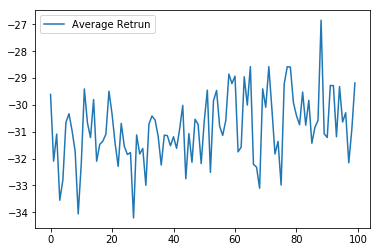

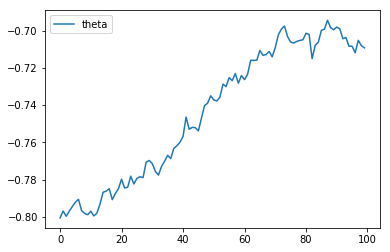

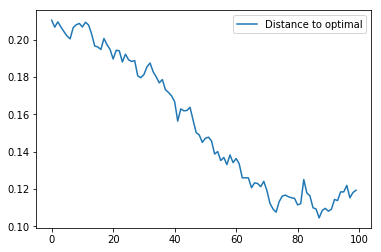

In [31]:
stepper = ConstantStep(0.0001)
T = 200
n_iter = 100
N = 500

mean_parameters, avg_return = REINFORCE(policy, 200, stepper, 100, 500)

Delta = np.abs(np.array(mean_parameters) - theta_opt)

plt.figure()
plt.plot(avg_return, label = "Average Retrun")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_parameters, label ="theta")
plt.legend()
plt.show()

plt.figure()
plt.plot(Delta, label ="Distance to optimal")
plt.legend()
plt.show()

M: 100%|███████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.05it/s]


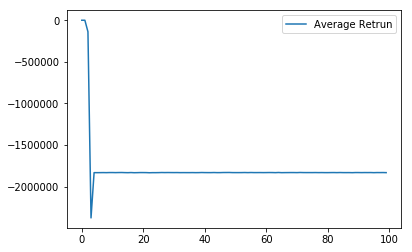

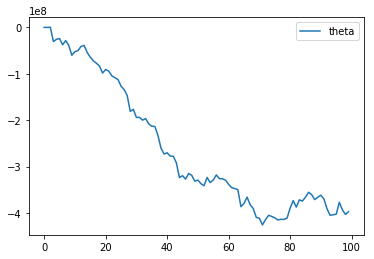

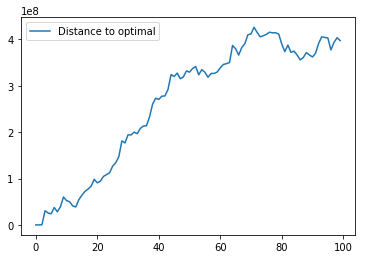

In [32]:
stepper = ConstantStep(0.01)
T = 100
n_item = 100
N = 100

mean_parameters, avg_return = REINFORCE(policy, T, stepper, 100, 100)

Delta = np.abs(np.array(mean_parameters) - theta_opt)

plt.figure()
plt.plot(avg_return, label = "Average Retrun")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_parameters, label ="theta")
plt.legend()
plt.show()

plt.figure()
plt.plot(Delta, label ="Distance to optimal")
plt.legend()
plt.show()

### Constant Step conclusion: We tried many parameters but we kept these two which show the huge impact of the choice of the learning rate. In the first case (0.0001) it seems to converge while in the second it diverges (the distance to the optimal increases exponentially!)

## Adam Step


M:   1%|▌                                                        | 1/100 [00:01<02:38,  1.60s/it]
Exception in thread Thread-19:
Traceback (most recent call last):
  File "C:\Users\youce\Anaconda3\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\youce\Anaconda3\lib\site-packages\tqdm\_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "C:\Users\youce\Anaconda3\lib\_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration

M: 100%|███████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.60s/it]


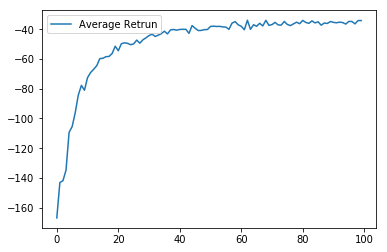

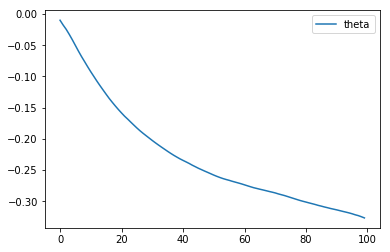

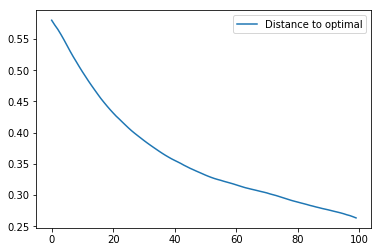

In [41]:
stepperAdam = AdamStep(0.01)
T = 100
n_iter = 100
N = 500
policy = Policy(0.5, 0)
mean_parameters_, avg_return_ = REINFORCE(policy, T, stepperAdam, 100, 500)

Delta_ = np.abs(np.array(mean_parameters_) - theta_opt)

plt.figure()
plt.plot(avg_return_, label = "Average Retrun")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_parameters_, label ="theta")
plt.legend()
plt.show()

plt.figure()
plt.plot(Delta_, label ="Distance to optimal")
plt.legend()
plt.show()

### As excpected, the Adam step gives better results and converges well

# Different Values of N (1 and higher)

M: 100%|██████████████████████████████████████████████████████| 100/100 [00:00<00:00, 159.82it/s]


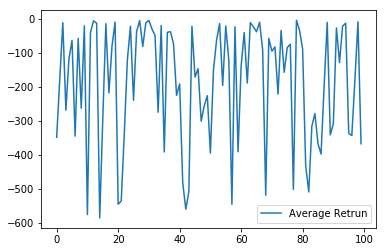

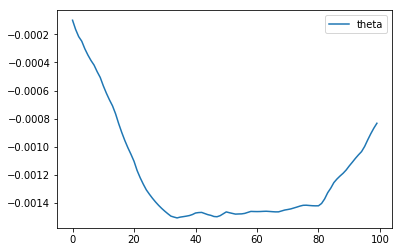

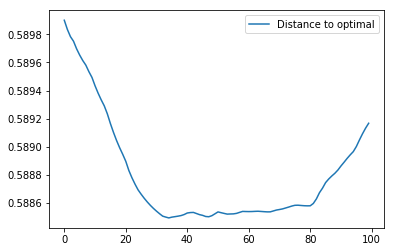

In [45]:
stepper = AdamStep(0.0001)
T = 200
n_iter = 100
N = 1
policy = Policy(0.5, 0)

mean_parameters, avg_return = REINFORCE(policy, T, stepper, n_iter, N)

Delta = np.abs(np.array(mean_parameters) - theta_opt)

plt.figure()
plt.plot(avg_return, label = "Average Retrun")
plt.legend()
plt.show()

plt.figure()
plt.plot(mean_parameters, label ="theta")
plt.legend()
plt.show()

plt.figure()
plt.plot(Delta, label ="Distance to optimal")
plt.legend()
plt.show()

M: 100%|███████████████████████████████████████████████████████| 100/100 [05:07<00:00,  3.08s/it]


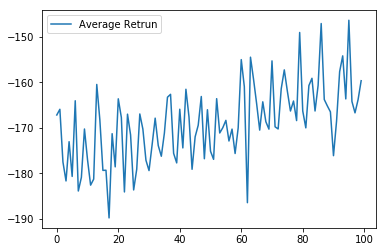

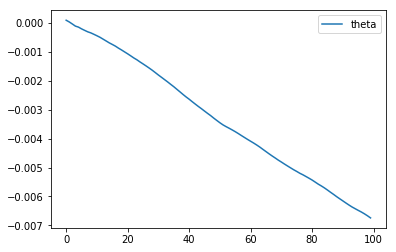

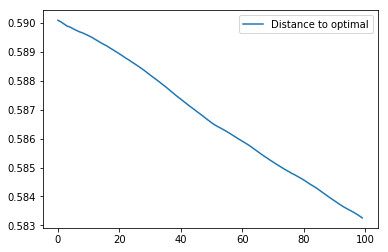

In [46]:
stepper = AdamStep(0.0001)
T = 200
n_iter = 100
N = 500
policy = Policy(0.5, 0)

_mean_parameters, _avg_return = REINFORCE(policy, T, stepper, n_iter, N)

_Delta = np.abs(np.array(_mean_parameters) - theta_opt)

plt.figure()
plt.plot(_avg_return, label = "Average Retrun")
plt.legend()
plt.show()

plt.figure()
plt.plot(_mean_parameters, label ="theta")
plt.legend()
plt.show()

plt.figure()
plt.plot(_Delta, label ="Distance to optimal")
plt.legend()
plt.show()

More iterations where needed to see convergence but obvisouly it would converge.

### We consider the parameters that worked well with constant rate and we only change N. The algoirthm won't converge for low value of N (stochastic gradient). For a high value, it will but it takes time. Hence there is tradeoff to do between convergence and duration. 